## Fast Gradient Sign Method

This is the method outlined in the original paper. It takes the sign of the gradient and uses it as noise to perturb the original image. 

In [2]:
#importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import inception

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

%matplotlib inline

## Trying with just a regular CNN

Here I built the basic CNN model using Keras. It's just a wrapper library that builds on top of either Tensorflow or Theano so all the code can still interact with basic tf code. 

In [3]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [4]:
batch_size = 128
num_classes = 10
epochs = 25

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
manual_variable_initialization(True)

In [6]:
from keras.metrics import categorical_accuracy as accuracy
labels = tf.placeholder(tf.float32, shape=(None, 10))

with tf.Session() as sess:
        
    model.load_weights('cnn_weights3.h5')
    
    xs = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    ys = model(xs)

    acc_value = accuracy(labels, ys)

    res = (acc_value.eval(feed_dict={xs: x_test,
                                    labels: y_test,
                                    K.learning_phase(): 0}))
    print("The original accuracy of the MNIST dataset: {}".format(np.mean(res)))

The original accuracy of the MNIST dataset: 0.960099995136261


## Building the adversarial noise generator

In [7]:
#initialized uninitialized variables
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    #print[str(i.name) for i in not_initialized_vars] # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))

the prediction for this image is:
[7]


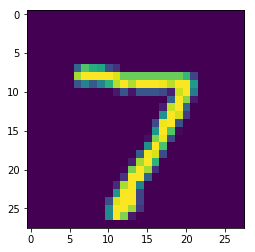

In [8]:
#plotting an example of an image and the prediction class
plt.imshow(x_test[0].squeeze())

with tf.Session() as sess:
    
    model.load_weights('cnn_weights3.h5')
    
    xs = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    ys = model(xs)
    
    pred = sess.run(ys, feed_dict={
        xs: [x_test[0]],
        K.learning_phase(): 0
    })
    
    print("the prediction for this image is:")
    print(np.argmax(pred, axis=1))

In [9]:
#The fast gradient sign method
#Takes an image, a class, and an "amplitude"
def fgsm(image, cls, amp):
        
    xs = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    ys = model(xs)
        
    with tf.Session() as sess:
        #load models
        model.load_weights('cnn_weights3.h5')
        initialize_uninitialized(sess)
        
        pred = sess.run(ys, feed_dict={
            xs: image,
            K.learning_phase(): 0
        })
                
        labels = tf.placeholder(tf.float32, shape=(None, 10))
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=ys, labels=labels)
        gradient = tf.gradients(loss, xs)[0]
        
        #get gradient of the prediction
        grad = sess.run(gradient, feed_dict={
            xs: image, 
            labels: cls, 
            K.learning_phase(): 0
        })
        
        #Return the sign of the prediction multiplied by the amplitude
        signed_grad = tf.sign(grad) * amp
        
        #pass back reduced dimensions
        return (grad.squeeze(), signed_grad.eval().squeeze())

In [17]:
#creating target array
tar = 7
cls = np.zeros(10)
cls[tar] = 1

#calling the method return a gradient and signed map
grad, signed = fgsm([x_test[0]], [cls], 0.5)

7


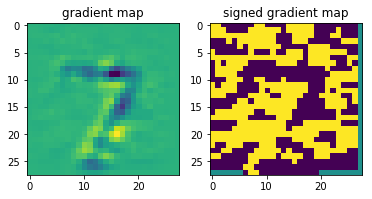

In [18]:
plt.subplot(121)
plt.imshow(grad)
plt.title('gradient map')

plt.subplot(122)
plt.imshow(signed)
plt.title('signed gradient map')

the prediction for this image is:
[3]


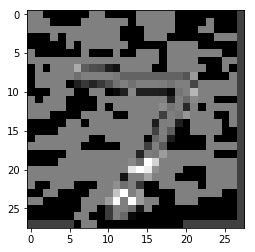

In [16]:
#Here I tried plotting the image with the added noise. It misclassifies! Which is cool
#but it also doesn't look very much like a 7 anymore. 

noisy_image = x_test[0] + signed.reshape((28, 28, 1))
plt.imshow(noisy_image.squeeze(), cmap='gray')

with tf.Session() as sess:
    
    model.load_weights('cnn_weights3.h5')
    
    xs = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    ys = model(xs)
    
    pred = sess.run(ys, feed_dict={
        xs: [noisy_image],
        K.learning_phase(): 0
    })
    
    print("the prediction for this image is:")
    print(np.argmax(pred, axis=1))